In [14]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos
data = pd.read_csv('../data/final_train.csv', index_col=0)

# Separar las características y la variable objetivo
X = data.drop(columns=['log_SalePrice'])
y = data['log_SalePrice']

# Estandarizar las características
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
X_scaled.dropna(inplace=True)

#Eliminar la fila eliminada en y tambien en X
dropped_rows = y.index.difference(X_scaled.index)
y_scaled = y.drop(index=dropped_rows)

In [15]:
# # De las correlaciones altas nos quedamos con las que tienen mas correlacion con la target
# corr_matrix = X_scaled.corr()

# #Eliminar las diagonales
# corr_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# corr_matrix = corr_matrix.stack().reset_index()
# corr_matrix.columns = ['Feature 1', 'Feature 2', 'Correlation']

# # De las parejas con abs(correlacion > 0.9) nos quedamos con la que tiene mas correlacion con la target
# corr_matrix = corr_matrix[corr_matrix['Correlation'].abs() > 0.9]
# corr_matrix = corr_matrix.sort_values(by='Correlation', ascending=False)

# # de la pareja eliminar la que menos corr tenga con la target y, usar corrwith
# features_to_drop = []
# for index, row in corr_matrix.iterrows():
#     feature1 = row['Feature 1']
#     feature2 = row['Feature 2']
#     if y.corr(X[feature1]) < y.corr(X[feature2]):
#         features_to_drop.append(feature1)
#     else:
#         features_to_drop.append(feature2)

# X_scaled = X_scaled.drop(columns=features_to_drop)

In [16]:
def custom_rmse_scorer(y_true, y_pred):
    try:
        mse = mean_squared_error(y_true, y_pred)
        if np.isnan(mse) or np.isinf(mse):
            print(f"MSE is {mse}")
            print(f"y_true: min={np.min(y_true)}, max={np.max(y_true)}, mean={np.mean(y_true)}")
            print(f"y_pred: min={np.min(y_pred)}, max={np.max(y_pred)}, mean={np.mean(y_pred)}")
        return np.sqrt(mse)
    except Exception as e:
        print(f"Error in RMSE calculation: {e}")
        print(f"y_true shape: {y_true.shape}, y_pred shape: {y_pred.shape}")
        print(f"y_true: {y_true[:5]}, y_pred: {y_pred[:5]}")
        return np.nan

rmse_scorer = make_scorer(custom_rmse_scorer, greater_is_better=False)
def custom_oversample_data(X, y:pd.Series, percentage=0.2, noise_level=1):
    #Random seed
    random_seed = 42

    np.random.seed(random_seed)
    y = y.apply(lambda x: np.exp(x))

    # Seleccionar de la mediana hacia arriba para hacer el oversampling
    median_value = y.median()
    y_median = y[y >= median_value]

    # Seleccionar aleatoriamente un porcentaje de los datos
    sample_size = int(len(y_median) * percentage)
    random_indices = np.random.choice(y_median.index, size=sample_size, replace=True)
        

    # Crear muestras con ruido
    X_sampled = X.loc[random_indices]
    y_sampled = y_median.loc[random_indices] + np.random.normal(0, noise_level, size=sample_size)
    
    # Combinar las muestras originales con las sobremuestreadas
    X_resampled = pd.concat([X, X_sampled], axis=0)
    y_resampled = pd.concat([y.apply(lambda x: np.log(x)), y_sampled.apply(lambda x: np.log(x))], axis=0)
    
    
    return X_resampled, y_resampled

In [23]:
import xgboost as xgb
# Función para crear DMatrix
def create_dmatrix(X, y):
    return xgb.DMatrix(X, label=y, feature_names=X.columns.tolist(), enable_categorical=True)

In [ ]:
import optuna
import xgboost as xgb
from xgboost import callback
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Configuración comn de Optuna
def create_study(name, version=None):
    return optuna.create_study(study_name=f'{name}_housing_{version}', directions = ['minimize', 'minimize'],
                               sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_min_trials=2),
                               load_if_exists=True, storage=f'sqlite:///../models/{name}_housing_{version}.db')

def objective_xgb(trial):
    do_oversampling = trial.suggest_categorical('do_oversampling', [True, False])
    do_poly = trial.suggest_categorical('do_poly', [True, False])
    # Definición de parámetros para XGBoost
    params_xgb = {
        'objective': trial.suggest_categorical('objective', ['reg:squarederror', 'reg:linear']),
        'device': 'cuda',
        'booster': trial.suggest_categorical('booster', ['gbtree']),
        'tree_method': 'hist',
        'max_depth': trial.suggest_int('max_depth', 3, 40),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.01, 1.0),
        'n_jobs': -1,
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 10),
        'max_bin': trial.suggest_int('max_bin', 256, 1024),
        'num_parallel_tree': trial.suggest_int('num_parallel_tree', 1, 10),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'eval_metric': 'rmse'
    }
    

    # Validación cruzada con XGBoost a partir de kfold y xgb.train
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    val_rmse_list = []
    diff_rmse_list = []

    for train_index, test_index in kfold.split(X_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        if do_poly:
            # Create polynomial features
            poly = PolynomialFeatures(degree=trial.suggest_int('degree_poly', 1, 2), interaction_only=do_poly)

            # Transform the data
            X_train_fold = pd.DataFrame(poly.fit_transform(X_train_fold), 
                                        index=X_train_fold.index, 
                                        columns=poly.get_feature_names_out())
            X_test_fold = pd.DataFrame(poly.transform(X_test_fold),  # Use transform instead of fit_transform
                                    index=X_test_fold.index, 
                                    columns=poly.get_feature_names_out())

            print(f'X_train_fold shape: {X_train_fold.shape}, X_test_fold shape: {X_test_fold.shape}')

            # Calculate correlation with target
            corr_matrix = X_train_fold.corrwith(y_train_fold)

            # Select features with correlation > 60%
            high_corr_features = corr_matrix[abs(corr_matrix) > 0.6].index.tolist()

            # Filter the datasets to keep only high correlation features
            X_train_fold = X_train_fold[high_corr_features]
            X_test_fold = X_test_fold[high_corr_features]

            print(f'After feature selection - X_train_fold shape: {X_train_fold.shape}, X_test_fold shape: {X_test_fold.shape}')
            print(f'Selected features: {high_corr_features}')
        
        dval = create_dmatrix(X_test_fold, y_test_fold)
        
        if do_oversampling:
            X_train_fold_over, y_train_fold_over = custom_oversample_data(X_train_fold, y_train_fold)
            X_train_fold_over = pd.DataFrame(X_train_fold_over,columns=X_train_fold.columns)
            dtrain_val = create_dmatrix(X_train_fold_over, y_train_fold_over)
        else:
            X_train_fold = pd.DataFrame(X_train_fold,columns=X_train_fold.columns)
            dtrain_val = create_dmatrix(X_train_fold, y_train_fold)
        # Configuración del entrenamiento
        num_boost_round = 1000
        early_stopping_rounds = 300
        evals = [(dtrain_val, 'train'), (dval, 'val')] #Es importante que el early stopping no sea sobre dtest puesto que estos datos no se conocen.

        # Definimos el callback para el early stopping sobre el conjunto de validación nunca el de test.
        EarlyStopping_callback = callback.EarlyStopping(metric_name='rmse', data_name='val', maximize=False, rounds=early_stopping_rounds, min_delta=0.001)

        # Entrenar el modelo
        evals_result = {}
        model = xgb.train(
            params_xgb,
            dtrain_val,
            num_boost_round=num_boost_round,
            evals=evals,
            evals_result=evals_result,
            early_stopping_rounds=early_stopping_rounds,
            callbacks=[EarlyStopping_callback],
            verbose_eval=100  # Mostrar métricas cada 100 rondas
        )

        # Encontrar la mejor ronda
        best_round = model.best_iteration

        val_rmse = evals_result['val']['rmse'][best_round-1]
        train_rmse = evals_result['train']['rmse'][best_round-1]
        diff_rmse = val_rmse - train_rmse

        val_rmse_list.append(val_rmse)
        diff_rmse_list.append(diff_rmse)

    mean_val_rmse = np.mean(val_rmse)
    mean_diff_rmse = np.mean(diff_rmse)
        
    return mean_val_rmse, mean_diff_rmse

study_xgb = create_study('xgb_No_FS_Poly', version='1.1')
study_xgb.optimize(objective_xgb, n_trials=100, show_progress_bar=True, gc_after_trial=True)

In [31]:
print(f'Direcciones de optimización: {study_xgb.directions}')
print(f'Nmero de ensayos: {study_xgb.trials.__len__()}')
# print(f'Mejor ensayo: {study_xgb.best_trial}') solo se puede utilizar si la optimización es simple no multiple
# print(f'Mejor valor: {study_xgb.best_value}') solo se puede utilizar si la optimización es simple no multiple
# print(f'Mejor hiperparámetros: {study_xgb.best_params}') solo se puede utilizar si la optimización es simple no multiple
study_xgb_df = study_xgb.trials_dataframe()
study_xgb_df.sort_values(by='values_0', ascending=True).head(5)

Direcciones de optimización: [<StudyDirection.MINIMIZE: 1>, <StudyDirection.MINIMIZE: 1>]
Nmero de ensayos: 76


,number,values_0,values_1,datetime_start,datetime_complete,duration,params_booster,params_colsample_bytree,params_degree_poly,params_do_oversampling,...,params_max_bin,params_max_delta_step,params_max_depth,params_min_child_weight,params_num_parallel_tree,params_objective,params_reg_alpha,params_reg_lambda,params_subsample,state
57,57,0.12,0.02,2024-07-26 03:57:16.872337,2024-07-26 03:57:37.301339,0 days 00:00:20.429002,gbtree,0.35,NaN,False,...,541,7,7,5,10,reg:squarederror,0.46,0.05,0.35,COMPLETE
53,53,0.12,0.03,2024-07-26 03:55:51.935986,2024-07-26 03:56:13.801427,0 days 00:00:21.865441,gbtree,0.38,NaN,False,...,542,7,8,8,7,reg:squarederror,0.26,0.15,0.52,COMPLETE
68,68,0.12,0.01,2024-07-26 03:59:55.331891,2024-07-26 04:00:10.461833,0 days 00:00:15.129942,gbtree,0.45,NaN,False,...,367,3,4,5,3,reg:squarederror,0.41,0.07,0.36,COMPLETE
27,27,0.12,0.03,2024-07-26 03:50:21.337269,2024-07-26 03:50:37.772599,0 days 00:00:16.435330,gbtree,0.37,NaN,False,...,546,7,7,5,10,reg:squarederror,0.61,0.14,0.36,COMPLETE
52,52,0.12,0.01,2024-07-26 03:55:31.353586,2024-07-26 03:55:51.815555,0 days 00:00:20.461969,gbtree,0.38,NaN,False,...,537,7,8,5,7,reg:squarederror,0.28,0.04,0.32,COMPLETE


In [32]:
def obtain_best_params(study_xgb, weights:np.ndarray) -> dict:
    '''
    Obtenemos los best params atraves de asociar un peso deseado a cada métrica que estamos optimizando
    -------
    Parámetros:
    - study_xgb: optuna.Study, estudio de Optuna.
    - weights: np.ndarray, pesos deseados para cada métrica.
    -------
    Devuelve:
    - best_params: dict, hiperparámetros óptimos.
    '''
    study_df = study_xgb.trials_dataframe()
    study_df['weighted_average'] = np.average(study_df[[col for col in study_df.columns if 'values' in col]], weights=weights, axis=1)

    # Encontrar el trial con el menor promedio ponderado
    best_trial_index = study_df['weighted_average'].idxmin()
    best_trial = study_df.loc[best_trial_index]

    best_trial = [trial for trial in study_xgb.best_trials if trial.number == best_trial_index]
    best_params = best_trial[0].params
    return best_params, best_trial[0].values

In [36]:
best_params, best_values = obtain_best_params(study_xgb, weights=np.array([0.75, 0.25]))
print(f'Mejores hiperparámetros: {best_params}')
print(f'Mejores valores: Mean rmse Validation: {best_values[0]}, Mean Diff (Val - Train) rmse: {best_values[1]}')

Mejores hiperparámetros: {'do_oversampling': False, 'do_poly': False, 'objective': 'reg:squarederror', 'booster': 'gbtree', 'max_depth': 8, 'learning_rate': 0.05793002021660699, 'min_child_weight': 5, 'gamma': 0.23101080276985825, 'subsample': 0.31733127328725247, 'colsample_bytree': 0.3755755928714486, 'reg_alpha': 0.2775244199436249, 'reg_lambda': 0.04287971121742291, 'max_delta_step': 7, 'max_bin': 537, 'num_parallel_tree': 7, 'grow_policy': 'depthwise'}
Mejores valores: Mean rmse Validation: 0.11999851154293736, Mean Diff (Val - Train) rmse: 0.009371975286237497


[0]	train-rmse:0.38000	val-rmse:0.39927	test-rmse:0.37211
[100]	train-rmse:0.11646	val-rmse:0.10929	test-rmse:0.11763
[200]	train-rmse:0.11302	val-rmse:0.10456	test-rmse:0.11617
[300]	train-rmse:0.11171	val-rmse:0.10279	test-rmse:0.11587
[400]	train-rmse:0.11099	val-rmse:0.10181	test-rmse:0.11585
[500]	train-rmse:0.11053	val-rmse:0.10147	test-rmse:0.11591
[539]	train-rmse:0.11034	val-rmse:0.10134	test-rmse:0.11590

Mejor ronda: 314
Mejor rmse en train: 0.111465
Mejor rmse en validación: 0.102485
Mejor rmse en test: 0.115766
Diferencia entre train y test: 0.004301


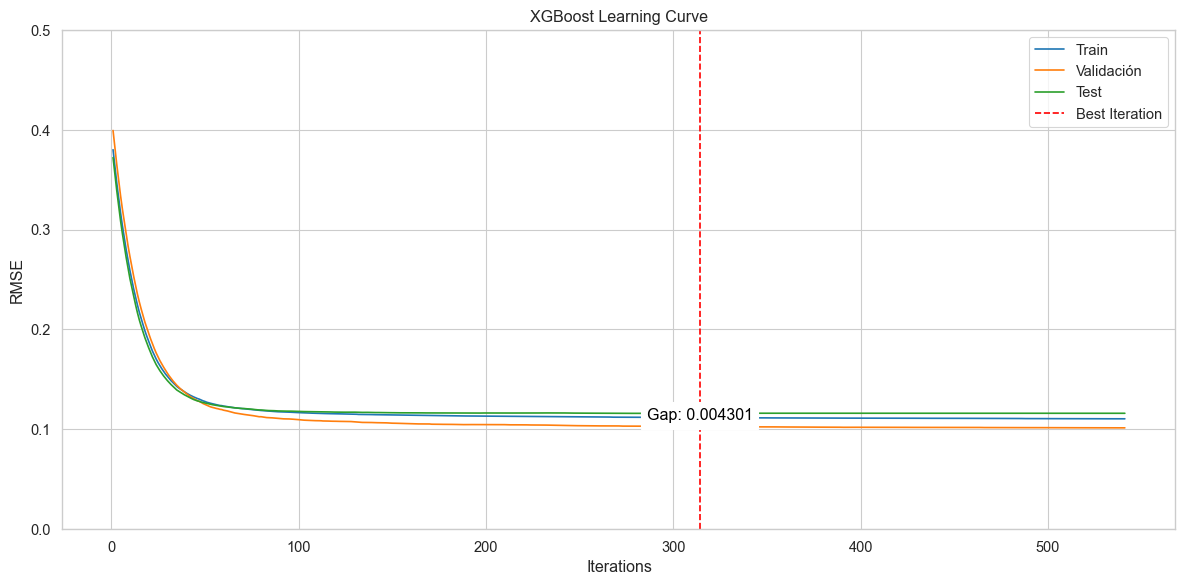

In [37]:
import numpy as np
import xgboost as xgb
from xgboost import callback
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Función para crear DMatrix
def create_dmatrix(X, y):
    return xgb.DMatrix(X, label=y, feature_names=X.columns.tolist())

# Dividir los datos de train en train y val
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

do_poly = best_params.pop('do_poly')
do_oversampling = best_params.pop('do_oversampling')

if do_poly:
    poly = PolynomialFeatures(degree=best_params.pop('degree_poly'), interaction_only=do_poly)

    # Transform the data
    X_train_val = pd.DataFrame(poly.fit_transform(X_train_val), 
                                index=X_train_val.index, 
                                columns=poly.get_feature_names_out())
    X_val = pd.DataFrame(poly.transform(X_val),  # Use transform instead of fit_transform
                            index=X_val.index, 
                            columns=poly.get_feature_names_out())
    X_test = pd.DataFrame(poly.transform(X_test),  # Use transform instead of fit_transform
                            index=X_test.index, 
                            columns=poly.get_feature_names_out())

    print(f'X_train_val shape: {X_train_val.shape}, X_val shape: {X_val.shape}')

    # Calculate correlation with target
    corr_matrix = X_train_val.corrwith(y_train_val)

    # Select features with correlation > 60%
    high_corr_features = corr_matrix[abs(corr_matrix) > 0.6].index.tolist()

    # Filter the datasets to keep only high correlation features
    X_train_val = X_train_val[high_corr_features]
    X_val = X_val[high_corr_features]
    X_test = X_test[high_corr_features]

# Crear DMatrix para los conjuntos de datos
dtrain = create_dmatrix(X_train, y_train)
dtrain_val = create_dmatrix(X_train_val, y_train_val)
dval = create_dmatrix(X_val, y_val)
dtest = create_dmatrix(X_test, y_test)

# Parámetros del modelo
params = {
    **best_params,
    'objective': 'reg:squarederror',
    'eval_metric': ['rmse'],
    'random_state': 42,
    'n_jobs': -1,
}

# Configuración del entrenamiento
num_boost_round = 1000
early_stopping_rounds = 400
evals = [(dtrain_val, 'train'), (dval, 'val'), (dtest, 'test')] #Es importante que el early stopping no sea sobre dtest puesto que estos datos no se conocen.

# Definimos el callback para el early stopping sobre el conjunto de validación nunca el de test.
EarlyStopping_callback = callback.EarlyStopping(metric_name='rmse', data_name='test', maximize=False, save_best=True, rounds=early_stopping_rounds, min_delta=0.001)

# Entrenar el modelo
evals_result = {}
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=evals,
    evals_result=evals_result,
    early_stopping_rounds=early_stopping_rounds,
    callbacks=[EarlyStopping_callback],
    verbose_eval=100  # Mostrar métricas cada 100 rondas
)

n_rounds = len(evals_result['train']['rmse'])

# Encontrar la mejor ronda
best_round = model.best_iteration

print(f"\nMejor ronda: {best_round}")
print(f"Mejor rmse en train: {evals_result['train']['rmse'][best_round-1]:.6f}")
print(f"Mejor rmse en validación: {evals_result['val']['rmse'][best_round-1]:.6f}")
print(f"Mejor rmse en test: {evals_result['test']['rmse'][best_round-1]:.6f}")
print(f"Diferencia entre train y test: {evals_result['test']['rmse'][best_round-1] - evals_result['train']['rmse'][best_round-1]:.6f}")

import matplotlib.pyplot as plt
import seaborn as sns

# Configurar el estilo de Seaborn
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 6))

# Graficar las curvas de aprendizaje
sns.lineplot(x=range(1, n_rounds+1), y=evals_result['train']['rmse'], label='Train', ax=ax)
sns.lineplot(x=range(1, n_rounds+1), y=evals_result['val']['rmse'], label='Validación', ax=ax)
sns.lineplot(x=range(1, n_rounds+1), y=evals_result['test']['rmse'], label='Test', ax=ax)

# Añadir la línea vertical para la mejor ronda
ax.axvline(x=best_round, color='r', linestyle='--', label='Best Iteration')

# Añadir el texto para el gap
ax.text(best_round, (evals_result['test']['rmse'][best_round-1] + evals_result['train']['rmse'][best_round-1]) / 2, 
        f"Gap: {evals_result['test']['rmse'][best_round-1] - evals_result['train']['rmse'][best_round-1]:.6f}", 
        color='black', ha='center', va='center', backgroundcolor='white')

# Ajustar ylim entre 0.5 y 0.7
ax.set_ylim(0, 0.5)

# Configurar etiquetas y título
ax.set_xlabel('Iterations')
ax.set_ylabel('RMSE')
ax.set_title('XGBoost Learning Curve')

# Ajustar la leyenda
ax.legend(loc='best')

# Mostrar la gráfica
plt.tight_layout()
plt.show()